In [1]:
# Refactored from Daniil's blog: TFRecords Guide
# http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

import argparse
import sys

import tensorflow as tf
import skimage.io as io
%matplotlib inline

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 3

FLAGS = None

In [2]:
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    
    # Convert from a scalar string tensor
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width =  tf.cast(features['width'], tf.int32)
    label = tf.cast(features['label'], tf.int32)
    
    image = tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
    return image, label   

In [3]:
def main(_):
    tfrecords_filename = FLAGS.record
    filename_queue = tf.train.string_input_producer([tfrecords_filename], num_epochs=10)
    
    # Even when reading in multiple threads, share the filename queue
    image, label = read_and_decode(filename_queue)
    images, labels = tf.train.shuffle_batch([image, label],
                                            batch_size=3,
                                            capacity=30,
                                            num_threads=4,
                                            min_after_dequeue=10)
    
    init_op = tf.local_variables_initializer()
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    
    with tf.Session(config=config) as sess:
        
        sess.run(init_op)
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in range(4):
            images_np, labels_np = sess.run([images, labels])
            
            print('\n%d-th batch' % (i+1))
            print('label: ', labels_np[0])
            io.imshow(images_np[0])
            io.show()
            
            print('label: ', labels_np[1])
            io.imshow(images_np[1])
            io.show()
            
            print('label: ', labels_np[2])
            io.imshow(images_np[2])
            io.show()
                        
        coord.request_stop()
        coord.join(threads)
        


1-th batch
label:  21


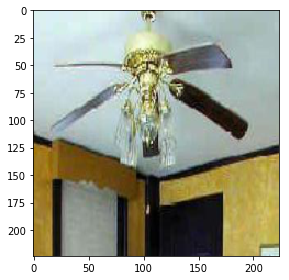

label:  95


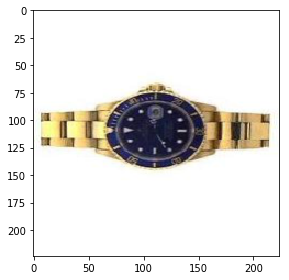

label:  52


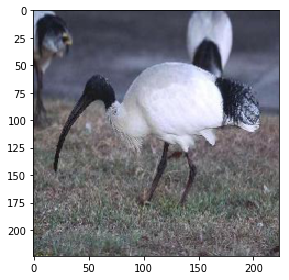


2-th batch
label:  1


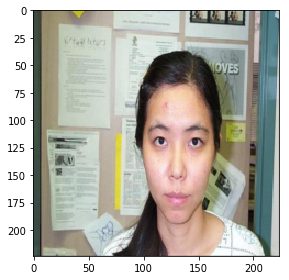

label:  27


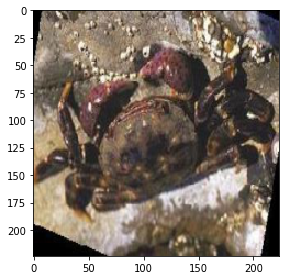

label:  6


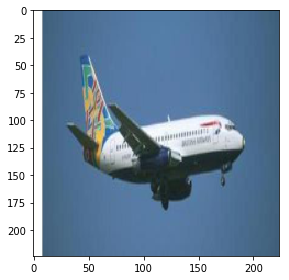


3-th batch
label:  44


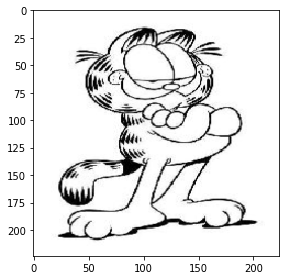

label:  2


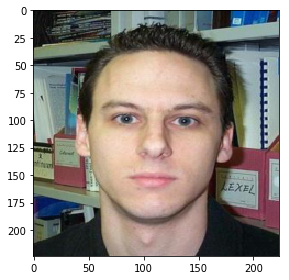

label:  6


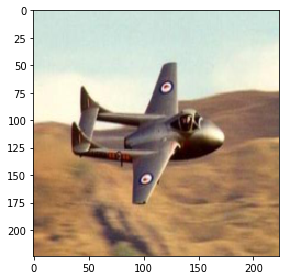


4-th batch
label:  4


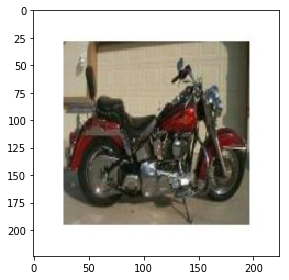

label:  0


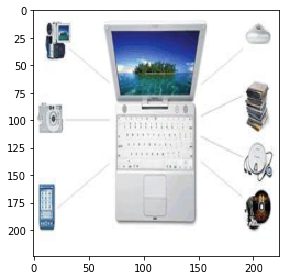

label:  61


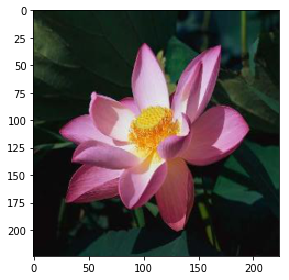

SystemExit: 

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--record',
        type=str,
        default='tmp/custom_train.tfrecords'
    )
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)